# SISO for Event History

In [1]:
import numpy as np
from mdof.utilities.printing import *
import mdof
from mdof import modal, transform
from mdof.utilities.config import Config

## Upload a Dataset and Identify Spectral Quantities

In [2]:
inputs = np.loadtxt("./uploads/opensees_sdof/Accgrd_set1.csv", delimiter=",")
outputs = np.loadtxt("./uploads/opensees_sdof/Accrsp_set1.csv", delimiter=",")
# inputs = np.loadtxt("./uploads/opensees_sdof/Accgrd_set2.csv", delimiter=",")
# outputs = np.loadtxt("./uploads/opensees_sdof/Accrsp_set2.csv", delimiter=",")
t = inputs[0,:]
dt = t[1] - t[0]

### Method Inputs

See [`01_SISO_Intro`](./01_SISO_Intro.ipynb) for parameter definitions

In [3]:
# Set parameters
conf = Config()
conf.m  = 300
conf.horizon = 140
conf.nc = 140
conf.order  =   2
conf.a  =   0
conf.b  =   0
conf.l  =  10
conf.g  =   3
conf.damping = 0.0001
conf.period_band = (0.1, 3.0)

### Perform System Identification

100%|█████████▉| 885/886 [00:00<00:00, 18971.38it/s]


   period(s)  damping
 [[0.41068031 0.02342356]
 [0.41083068 0.02249289]
 [0.4107063  0.00068529]
 [0.41201371 0.02015356]
 [0.41051848 0.02368659]
 [0.4112227  0.02544649]
 [0.40933146 0.01991049]
 [0.41281326 0.0191038 ]
 [0.40928958 0.02311352]
 [0.41883737 0.0023086 ]
 [0.40943662 0.02034821]]


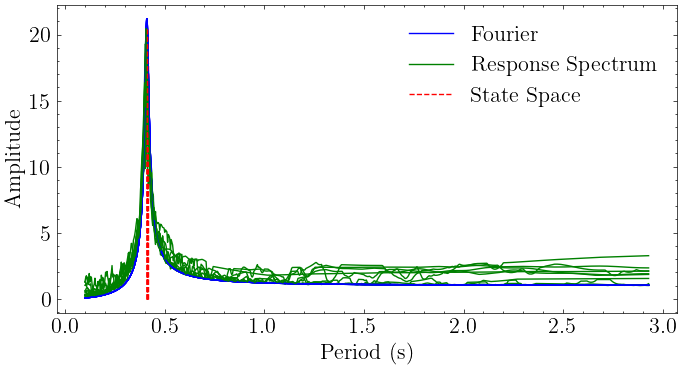

In [4]:
mode_predictions = np.empty((inputs.shape[0]-1, 2))
plt.rc
fig, ax = plt.subplots(figsize=(8,4))
for i,motion in enumerate(inputs[1:,:]):
    conf.decimation = 8         # transfer function decimation
    A,B,C,D = mdof.system(method="srim", inputs=motion, outputs=outputs[i+1,:], **conf)
    ss_modes = modal.system_modes((A,B,C,D),dt,decimation=conf.decimation)
    mode_predictions[i,:] = [[1/v["freq"], v["damp"]] for v in ss_modes.values()][0]  # save predicted period and damping
    conf.decimation = 1         # transfer function decimation
    periods, amplitudes = transform.fourier_transfer(inputs=motion, outputs=outputs[i+1,:], step=dt, **conf)
    ax.plot(periods, amplitudes, color="blue", label=["Fourier" if i==0 else None][0])
    periods, amplitudes = transform.response_transfer(inputs=motion, outputs=outputs[i+1,:], step=dt, periods=periods, threads=10, **conf)
    ax.plot(periods, amplitudes, color="green", label=["Response Spectrum" if i==0 else None][0])
    ax.vlines([1/v["freq"] for v in ss_modes.values()], 0, max(amplitudes), colors="r", linestyles="--", label=["State Space" if i==0 else None][0])
plt.legend()
plt.xlabel("Period (s)")
plt.ylabel("Amplitude")
print("   period(s)  damping\n", mode_predictions)